In [1]:
import time
import copy
import warnings
import hdbscan
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import v_measure_score
from HiPart.clustering import dePDDP
from sklearn.base import clone
import matplotlib.pyplot as plt
from classix import CLASSIX
from quickshift.QuickshiftPP import *
from threadpoolctl import threadpool_limits
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")


def rn_sklearn_benchmark():
    plt.style.use('bmh')
    plot_num = 1
    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============
    n_samples = 1500
    np.random.seed(0)
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                          noise=.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
    no_structure = np.random.rand(n_samples, 2), None

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    # ============
    # Store scores
    clustering_algorithms_scores_ari = {
        'k-means++' : [],
        'Agglomerative\nClustering' : [],
        'Gaussian\nMixture' : [],
        'Mean Shift': [],
        'DBSCAN' : [],
        'BIRCH' : [],
        'OPTICS' : [],
        'Spectral\nClustering' : [],
        'Affinity\nPropagation' : [],
        'dePDDP' : [],
        'HDBSCAN': [],
        'Quickshift++': [],
        'CLASSIX\n(distance)': [],
        'CLASSIX\n(density)': []
    }

    clustering_algorithms_scores_ami = {
        'k-means++' : [],
        'Agglomerative\nClustering' : [],
        'Gaussian\nMixture' : [],
        'Mean Shift': [],
        'DBSCAN' : [],
        'BIRCH' : [],
        'OPTICS' : [],
        'Spectral\nClustering' : [],
        'Affinity\nPropagation' : [],
        'dePDDP' : [],
        'HDBSCAN': [],
        'Quickshift++': [],
        'CLASSIX\n(distance)': [],
        'CLASSIX\n(density)': []
    }
    
    clustering_algorithms_scores_fm = {
        'k-means++' : [],
        'Agglomerative\nClustering' : [],
        'Gaussian\nMixture' : [],
        'Mean Shift': [],
        'DBSCAN' : [],
        'BIRCH' : [],
        'OPTICS' : [],
        'Spectral\nClustering' : [],
        'Affinity\nPropagation' : [],
        'dePDDP' : [],
        'HDBSCAN': [],
        'Quickshift++': [],
        'CLASSIX\n(distance)': [],
        'CLASSIX\n(density)': []
    }

    clustering_algorithms_scores_vm = {
        'k-means++' : [],
        'Agglomerative\nClustering' : [],
        'Gaussian\nMixture' : [],
        'Mean Shift': [],
        'DBSCAN' : [],
        'BIRCH' : [],
        'OPTICS' : [],
        'Spectral\nClustering' : [],
        'Affinity\nPropagation' : [],
        'dePDDP' : [],
        'HDBSCAN': [],
        'Quickshift++': [],
        'CLASSIX\n(distance)': [],
        'CLASSIX\n(density)': []
    }
    # ============

    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(13 * 2 + 3, 13))
    plt.rcParams['axes.facecolor'] = 'white'
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                        hspace=.01)

    default_base = {'quantile': .3,
                    'eps': .3,
                    'damping': .9,
                    'preference': -200,
                    'n_neighbors': 10,
                    'n_clusters': 3,
                    'min_samples': 20,
                    'xi': 0.05,
                    'min_cluster_size': 0.1
                   }

    _datasets = [
        (noisy_circles, {'damping': .77, 'preference': -240,
                         'quantile': .2, 'n_clusters': 2,
                         'min_samples': 20, 'xi': 0.25}),
        (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
        (varied, {'eps': .18, 'n_neighbors': 2,
                  'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
        (aniso, {'eps': .15, 'n_neighbors': 2,
                 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
        (blobs, {}),
        (no_structure, {})
    ]

    params_clx1 = {'tols': [0.25, 0.18, 0.09, 0.12, 0.15, 1],
                  'sorting': ['pca', 'pca', 'pca', 'pca', 'pca', 'pca'],
                  'minPts':[0, 0, 12, 12, 0, 0]
    }

    params_clx2 = {'tols': [0.21, 0.3, 0.13, 0.12, 0.2, 1],
                  'sorting': ['pca', 'pca', 'pca', 'pca', 'pca', 'pca'],
                  'minPts':[0, 0, 19, 9, 0, 0]
    }
    
    sample_size = 10

    quicks_k = [20]*6
    quicks_beta = [0.7]*6

    with threadpool_limits(limits=1, user_api='blas'):
        for i_dataset, (dataset, algo_params) in enumerate(_datasets):
            # update parameters with dataset-specific values

            # print('sorting:{}, alpha:{:.2f}'.format(
            #     params_clx['sorting'][i_dataset],
            #     np.round(params_clx['tols'][i_dataset],1)
            # ))
            # if i_dataset != 2:
            #     continue

            params = default_base.copy()
            params.update(algo_params)

            X, y = dataset

            # normalize dataset for easier parameter selection
            X = StandardScaler().fit_transform(X)

            # estimate bandwidth for mean shift
            bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

            # connectivity matrix for structured Ward
            connectivity = kneighbors_graph(
                X, n_neighbors=params['n_neighbors'], include_self=False)
            # make connectivity symmetric
            connectivity = 0.5 * (connectivity + connectivity.T)

            # ============
            # Create cluster objects
            # ============

            classix1 = CLASSIX(sorting=params_clx1['sorting'][i_dataset],
                        radius=params_clx1['tols'][i_dataset], 
                        group_merging='distance', verbose=0,
                        minPts=params_clx1['minPts'][i_dataset]
                      )

            classix2 = CLASSIX(sorting=params_clx2['sorting'][i_dataset],
                        radius=params_clx2['tols'][i_dataset], 
                        group_merging='density', verbose=0,
                        minPts=params_clx2['minPts'][i_dataset]
                      )

            ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

            kmeanspp = KMeans(n_clusters=params['n_clusters'], 
                              random_state=0, init='k-means++')


            spectral = cluster.SpectralClustering(
                n_clusters=params['n_clusters'], eigen_solver='arpack',
                affinity="nearest_neighbors", n_jobs=1)

            optics = cluster.OPTICS(min_samples=params['min_samples'],
                                    xi=params['xi'], n_jobs=1,
                                    min_cluster_size=params['min_cluster_size'])

            affinity_propagation = cluster.AffinityPropagation(
                damping=params['damping'], preference=params['preference'])

            average_linkage = cluster.AgglomerativeClustering(
                linkage="average", affinity="cityblock",
                n_clusters=params['n_clusters'], connectivity=connectivity)

            birch = cluster.Birch(n_clusters=params['n_clusters'])

            gmm = mixture.GaussianMixture(
                n_components=params['n_clusters'], covariance_type='full')
            
            depddp = dePDDP(max_clusters_number=params['n_clusters'])
            dbscan = cluster.DBSCAN(eps=params['eps'], n_jobs=1)

            hdbscan_boruvka = hdbscan.HDBSCAN(algorithm='best', core_dist_n_jobs=1)
            quicks = QuickshiftPP(k=quicks_k[i_dataset], beta=quicks_beta[i_dataset])

            clustering_algorithms = (
                ('k-means++', kmeanspp),
                ('Agglomerative\nClustering', average_linkage),
                ('Gaussian\nMixture', gmm),
                ('Mean Shift', ms),
                ('DBSCAN', dbscan),
                ('BIRCH', birch),
                ('OPTICS', optics),
                ('Spectral\nClustering', spectral),
                ('Affinity\nPropagation', affinity_propagation),
                ('dePDDP', depddp),
                ('HDBSCAN', hdbscan_boruvka),
                ('Quickshift++', quicks),
                ('CLASSIX\n(distance)', classix1),
                ('CLASSIX\n(density)', classix2)
            )
            
            classix_dist_nr1 = 0
            classix_dist_nr2 = 0
            for name, algorithm in clustering_algorithms:
                np.random.seed(0)
                unit_time = 0

                for _iter in range(sample_size):
                    np.random.seed(_iter)
                    algorithm_clone = copy.deepcopy(algorithm)
                    t0 = time.time()
                    # catch warnings related to kneighbors_graph
                    with warnings.catch_warnings():
                        warnings.filterwarnings(
                            "ignore",
                            message="the number of connected components of the " +
                            "connectivity matrix is [0-9]{1,2}" +
                            " > 1. Completing it to avoid stopping the tree early.",
                            category=UserWarning)
                        warnings.filterwarnings(
                            "ignore",
                            message="Graph is not fully connected, spectral embedding" +
                            " may not work as expected.",
                            category=UserWarning)
                        if name != 'Quickshift++':
                            algorithm_clone.fit(X)
                        else:
                            algorithm_clone.fit(X.copy(order='C'))

                    if hasattr(algorithm_clone, 'labels_'):
                        y_pred = algorithm_clone.labels_.astype(int)
                    elif name == 'Quickshift++':
                        y_pred = algorithm_clone.memberships
                    else:
                        y_pred = algorithm_clone.predict(X)

                    t1 = time.time()
                    unit_time = unit_time + t1 - t0

                    if name == 'CLASSIX\n(distance)':
                        classix_dist_nr1 = classix_dist_nr1 + algorithm_clone.nrDistComp_
                    if name == 'CLASSIX\n(density)':
                        classix_dist_nr2 = classix_dist_nr2 + algorithm_clone.nrDistComp_
                
                if i_dataset == 5:
                    y = np.ones(len(y_pred))

                classix_dist_nr1 = classix_dist_nr1 / sample_size
                classix_dist_nr2 = classix_dist_nr2 / sample_size
                
                ari = metrics.adjusted_rand_score(y, y_pred)
                ami = metrics.adjusted_mutual_info_score(y, y_pred)
                fm = fowlkes_mallows_score(y, y_pred)
                vm = v_measure_score(y, y_pred)
                
                clustering_algorithms_scores_ari[str(name)].append(ari)
                clustering_algorithms_scores_ami[str(name)].append(ami)
                clustering_algorithms_scores_fm[str(name)].append(fm)
                clustering_algorithms_scores_vm[str(name)].append(vm)
                
                plt.subplot(len(_datasets), len(clustering_algorithms), plot_num)
                if i_dataset == 0:
                    plt.title(name, size=21)

                colors = np.array(list(islice(cycle(['#984ea3', '#17becf', '#ff7f00', '#4daf4a',
                                                     '#f781bf', '#a65628', '#377eb8',
                                                     '#999999', '#e41a1c', '#dede00']),
                                              int(max(y_pred) + 1))))

                # add black color for outliers (if any)
                colors = np.append(colors, ["#000000"])
                # plt.rc('font', family='serif')
                plt.scatter(X[:, 0], X[:, 1], s=8, color=colors[y_pred])
                plt.xlim(-2.5, 2.5)
                plt.ylim(-2.5, 2.5)
                plt.xticks(())
                plt.yticks(())
                if name == 'CLASSIX\n(distance)':
                    plt.text(.01, .01, ('%.2f' % (classix_dist_nr1/len(y))), #.lstrip('0')
                             transform=plt.gca().transAxes, size=23,
                             horizontalalignment='left')
                if name == 'CLASSIX\n(density)':
                    plt.text(.01, .01, ('%.2f' % (classix_dist_nr2/len(y))),
                             transform=plt.gca().transAxes, size=23,
                             horizontalalignment='left')
                plt.text(.99, .01, ('%.2fs' % (unit_time/sample_size)), #.lstrip('0'),
                         transform=plt.gca().transAxes, size=23,
                         horizontalalignment='right')
                plot_num += 1

    plt.savefig('results/exp3/general_test.jpeg', bbox_inches='tight')
    # plt.show()

    aricsv = pd.DataFrame(clustering_algorithms_scores_ari)
    amicsv = pd.DataFrame(clustering_algorithms_scores_ami)
    fmcsv = pd.DataFrame(clustering_algorithms_scores_fm)
    vmcsv = pd.DataFrame(clustering_algorithms_scores_vm)
    
    aricsv.to_csv('results/exp3/aricsv_en.csv', index=False)
    amicsv.to_csv('results/exp3/amicsv_en.csv', index=False)
    fmcsv.to_csv('results/exp3/fmcsv_en.csv', index=False)
    vmcsv.to_csv('results/exp3/vmcsv_en.csv', index=False)

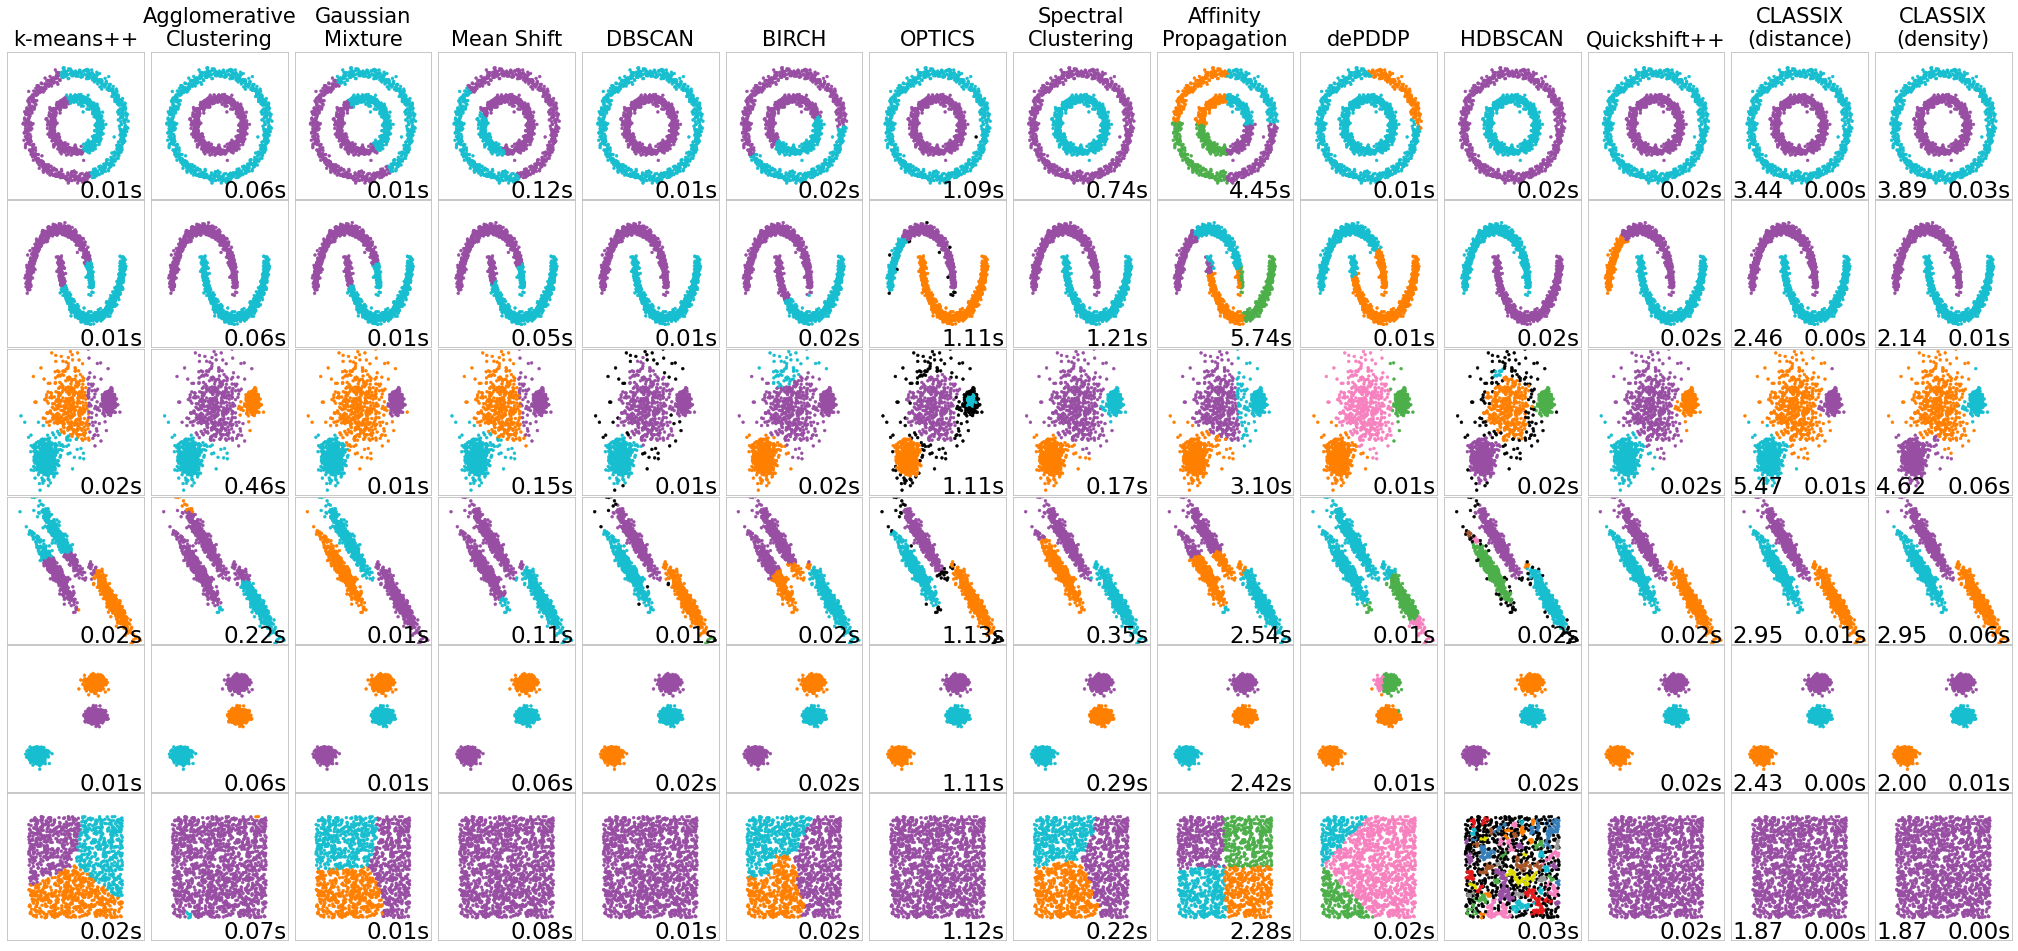

In [2]:
rn_sklearn_benchmark()